In [1]:
import torch
import torchvision
import tarfile
from torch import nn, optim
from torch.autograd import Variable

import numpy as np
import math

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [2]:
project_name='facial-expression-reinforcement'

In [3]:
path = '../fer2013.csv'

data_df = pd.read_csv(path)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [4]:
print('samples:', len(data_df))

print(data_df['Usage'].nunique())
print(data_df['Usage'].unique())

samples: 35887
3
['Training' 'PublicTest' 'PrivateTest']


In [5]:
trainData = data_df[data_df['Usage'] == 'Training']
testData = data_df[data_df['Usage'] != 'Training']
print(f'training samples:{len(trainData)}\n testing samples:{len(testData)}')

training samples:28709
 testing samples:7178


In [6]:
labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
print(labels)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [7]:
# creating tensors from input pixels
tensorData = torch.as_tensor([[float(i) for i in trainData['pixels'][j].split(' ')] for j in range(len(trainData))])

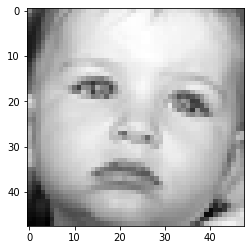

In [8]:
plt.imshow(tensorData[1500].reshape([48, 48]), cmap='gray')

In [9]:
K = 250

normTensor = nn.functional.normalize(tensorData)


U, S, V = torch.pca_lowrank(normTensor, q=K, center=True)

In [10]:
U.shape

torch.Size([28709, 250])

In [11]:
S.shape

torch.Size([250])

In [12]:
V.shape

torch.Size([2304, 250])

In [13]:
# this is the matrix multiplication that performs the PCA
kComponents = torch.matmul(normTensor, V[:, :K])

xapprox  = torch.matmul(kComponents ,V.T[:K, :])

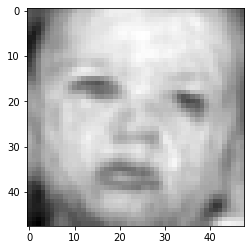

In [14]:
# recreation of image from xapprox (which used the k-components)
plt.imshow(torch.reshape(xapprox[1500], [48, 48]), cmap='gray')

In [35]:
# first, find the mean and variance of each class using tensors
print(kComponents.shape)

means = [kComponents[trainData['emotion'] == i].mean(axis=0) for i in labels]
variances = [kComponents[trainData['emotion'] == i].std(axis=0).square() for i in labels]

torch.Size([28709, 250])


In [46]:
for i in range(7):
    means[i] = means[i].numpy()
    variances[i] = variances[i].numpy()

In [ ]:
# prepping for mean & variation by class.
pixelDF = np.array([trainData[trainData['emotion'] == i]['pixels'] for i in labels ])

pixelarr = np.array([np.array([np.array(pixelDF[i][j].split(' '), dtype=float) for j in pixelDF[i].index]) for i in labels])

In [464]:
# first, find the mean & variance of each class
means = np.array([pixelarr[i].mean(axis=0) for i in labels])
variances = np.power(p.array([pixelarr[i].std(axis=0) for i in labels]), 2)

In [47]:
# rank features
# feature Ranking

FDR = []
for j in range(len(means)-1):
    for i in range(1,len(means)):
        if i == j:
            continue
        numerator = np.power(means[j] - means[i], 2)
        denom = variances[j] + variances[i]
        result = numerator/denom
        FDR.append(result)

FDR
FDR = (1/3)*np.sum(FDR, 0)

In [54]:
"""print(np.where(FDR == max(FDR)))

print(max(FDR), FDR[744])

print( np.argpartition(FDR, -250)[-250:])

print(normTensor[0, 1862], np.where(np.isclose(kComponents, normTensor[0, 1862])))"""
indices = np.argpartition(FDR, -2)[-2:]

FDR[indices]

array([0.40013194, 0.5660231 ], dtype=float32)

(array([[ 52.,  14.,   6.,  13.,   8.,   4.,   2.,   0.,   0.,   1.],
        [101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([-0.4537282,  2.4916446,  5.4370174,  8.38239  , 11.327763 ,
        14.273136 , 17.21851  , 20.163881 , 23.109255 , 26.054626 ,
        29.       ], dtype=float32),
 <a list of 2 BarContainer objects>)

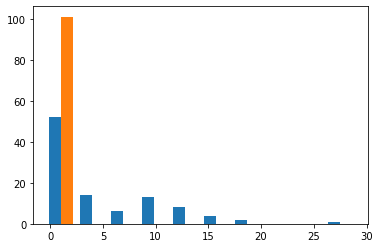

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

hist = kComponents[:500, 3].histogram()

plt.hist(hist)

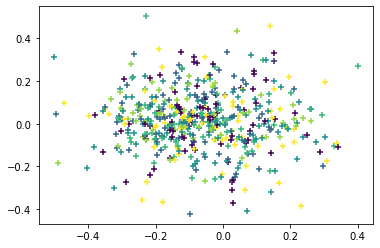

In [16]:
plt.scatter(kComponents[:500, 0], kComponents[:500, 1], c=trainData['emotion'][:500], marker='+')

In [112]:
from scipy.stats import kurtosis as kurt
def generate_samples(n):
    r = (abs(kComponents[:500, 0].mean() - kComponents[:500, 1].mean())/abs(kComponents[:500, 0].std() - kComponents[:500, 1].std())) + torch.rand(n,1)*0.1
    theta = abs((kurt(kComponents[:500, 0]) - kurt(kComponents[:500, 1]))/2)*3.1415926*torch.rand(n,1)
    x = torch.cos(theta)*r
    y = torch.sin(theta)*r
    
    return x, y

In [180]:
BINS = 250
hist = kComponents[0, :].histogram(bins=BINS)

torch.multinomial(hist[0], 250)#int(hist[0].sum().item()))



tensor([ 75,  79,  72,  74,  65,  76,  82,  73, 111,  77,  78,  24,  71,  70,
         69,  67,  66,  87,  92,  37,  64,  68,  80,  53,  17,  81,  86,  63,
         34,  10,  96,  91,  35, 166,  95, 121,  55, 113,  54, 249,  62,  89,
          0,  48, 158,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,  15,
         16,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,  30,  32,
         33,  36,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  49,  50,
         51,  52,  56,  57,  58,  59,  60,  61,  31,  83,  84,  85,  88,  90,
         93,  94,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 112, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157,   1, 159, 160, 161, 162, 163, 164, 165,   2, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [132]:
from sklearn.mixture import GaussianMixture

kComponents

gm = GaussianMixture(n_components=7).fit(kComponents)

In [133]:
pred_y = gm.predict(kComponents)

In [17]:
from torch.autograd import Variable
from torch.nn import GELU
import torch.nn.functional as F

In [18]:
Ns = kComponents.size()[0]
Ni = kComponents.size()[1]
No = len(labels)
a = 2

Neurons = Ns // (a * (Ni + No))

print(Neurons)

55


In [19]:
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        Ns = kComponents.size()[0]
        Ni = kComponents.size()[1]
        No = len(labels)
        a = 3

        Nh = 128#Ns // (a * (Ni + No))
        
        #250 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(250, Nh)
        
        # hidden layers
        self.fc2 = torch.nn.Linear(Nh, Nh)


        #outlayer 7 classes defined
        self.fc3 = torch.nn.Linear(Nh, 7)

    def forward(self, x):
        gelu = GELU()
        #lsm = LogSoftmax()
        #silu = SiLU()
        # first FC layer
        #x = F.relu(self.fc1(x))
        x = gelu(self.fc1(x))
        #x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 7) for each expression
        #x = self.fc3(x)
        x = self.fc3(x)
        return(x)

In [20]:
test = SimpleModel()

#Construct the loss function
criterion = torch.nn.GaussianNLLLoss()
#criterion = torch.nn.CrossEntropyLoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)

# yielded 91% accuracy with current model:
optimizer = torch.optim.LBFGS(test.parameters(), lr = 1.25, max_iter=25, tolerance_grad=1e-6, tolerance_change=1e-09, history_size=50)

#optimizer = torch.optim.SGD(test.parameters(), lr=1.25) 
#optimizer = torch.optim.ASGD(test.parameters(), lr=0.165, lambd=0.1, alpha=0.001, t0=1e6, weight_decay=0)


In [23]:
M = 10000#kComponents.shape[0]

In [1226]:
def closure():
    inputs = Variable(kComponents[:M])
    optimizer.zero_grad()
    y_pred = test.forward(inputs)
    
    var = y_pred.var(axis=1)
    
    # Compute and print loss
    loss = criterion(y_pred, zs[:M], var)
    loss.backward()
    return loss

In [658]:
# getting labels
y = torch.tensor(trainData['emotion'])

In [22]:
# transforming single column labels into a 7 element vector for each example
zs = torch.zeros(kComponents.shape[0], 7)#kComponents.shape[0], 7)

for i in range(zs.shape[0]):
    for j in range(zs.shape[1]):
        if y[i] == j:
            zs[i][j] = 1

In [1229]:
# training the network, can use kComponents[:500]
for epoch in range(100):
    inputs = Variable(kComponents[:M])
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = test.forward(inputs)
    
    var = y_pred.var(axis=1)
    
    # Compute and print loss
    loss = criterion(y_pred, zs[:M], var)
    
    #if test.fc1.weight.grad != None:
    #    print(test.fc1.weight.grad.mean())
    #    print(test.fc2.weight.grad.mean())
    #    print(test.fc3.weight.grad.mean())
    #    print(test.fc4.weight.grad.mean())
        
    if epoch%10 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()

    # perform a backward pass (backpropagation)
    loss.backward()

    # Update the parameters
    optimizer.step(closure)

epoch:  0  loss:  0.39408260583877563
epoch:  10  loss:  7.909710884094238
epoch:  20  loss:  7.723777770996094
epoch:  30  loss:  nan
epoch:  40  loss:  nan
epoch:  50  loss:  nan
epoch:  60  loss:  nan
epoch:  70  loss:  nan
epoch:  80  loss:  nan
epoch:  90  loss:  nan


In [1203]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [1230]:
test_pred = test.forward(kComponents)
print(test_pred.shape, zs.shape)
print(accuracy(test_pred, y))
print(torch.max(test_pred[:10], dim=1))

torch.Size([28709, 7]) torch.Size([28709, 7])
tensor(0.1392)
torch.return_types.max(
values=tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [1121]:
print(test_pred[:10], zs[:10], sep='\n')

tensor([[ 0.3992, -0.3311,  0.0758, -0.1371,  0.7896, -0.2750,  0.4805],
        [ 0.4198, -0.0770,  0.2386,  0.1506,  0.6157, -0.1400, -0.2074],
        [ 0.1162, -0.1888,  0.3820,  0.1440,  0.5456, -0.1655,  0.1693],
        [ 0.0071, -0.0968, -0.0981,  0.2730,  0.7053,  0.0055,  0.2000],
        [ 0.0879, -0.1961,  0.3253, -0.0662,  0.1065,  0.1439,  0.6050],
        [ 0.1035, -0.3049,  0.2988, -0.0509,  0.7629, -0.2458,  0.4358],
        [ 0.0750, -0.1951,  0.0965,  0.3361,  0.6650, -0.1477,  0.1679],
        [ 0.1149, -0.1433,  0.1375,  0.4772,  0.2969,  0.0312,  0.0821],
        [ 0.2133, -0.1386,  0.0206,  0.6236,  0.0059,  0.0379,  0.2510],
        [ 0.0761, -0.2634,  0.4974,  0.1949,  0.1046,  0.2556,  0.1211]],
       grad_fn=<SliceBackward0>)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        

In [752]:
len(testData['pixels'].values[1].split(' '))

2304

In [756]:
X_train, y_train = normTensor.reshape(normTensor.shape[0], 1, 48, 48), y

X_test = torch.as_tensor([[float(i) for i in testData['pixels'][j].split(' ')] for j in testData.index])

#X_test = X_test.reshape(X_test.shape[0], 1, 48, 48)

y_test = torch.tensor(testData['emotion'].values)

In [665]:
# Simple PCA function using Torch's tensors
def PCA(indata, K=250):
    # normalize tensors
    normTensor = F.normalize(indata)

    U, S, V = torch.pca_lowrank(normTensor, q=K, center=True)

    # this is the matrix multiplication that performs the PCA
    kComps = torch.matmul(normTensor, V[:, :K])
    
    return kComps

# Preparing train
X_test = PCA(X_test, K=250)

In [758]:
X_tsconv = torch.as_tensor([[float(i) for i in testData['pixels'][j].split(' ')] for j in testData.index])

In [759]:
X_tsconv = X_tsconv.reshape(X_tsconv.shape[0], 1, 48, 48)

In [647]:
# Convolutional Neural Net
class MLP(nn.Module):
    def __init__(self, n_hid=8, epochs=3, eta=0.05, mB=1000):
        super(MLP, self).__init__()
        self.n_hid, self.epochs, self.eta, self.mB = n_hid, epochs, eta, mB
        
        self.optimizer = None
        self.loss_func = nn.GaussianNLLLoss()#nn.CrossEntropyLoss()#
        
        self.net = nn.Sequential(
            nn.Conv2d(1, self.n_hid, 8),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(self.n_hid),

            nn.Conv2d(self.n_hid, self.n_hid*2, 8),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Flatten(start_dim=1),
            
            # 9*9 is computed in the above cell - based on 48x48 image size
            nn.Linear(self.n_hid*2 * 9 * 4, 128),  # 256 arbitrary
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 7),
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(kComponents.shape[1], self.n_hid),
            nn.GELU(),
            #nn.Softplus(),
            
            nn.Linear(self.n_hid, self.n_hid),
            nn.Softplus(),
            
            nn.Linear(self.n_hid, 7),
        )

    def _forward(self, _X, apply_softmax=False):
        import torch.nn.functional as F
        out = self.net2(_X)
        if apply_softmax:
            out = F.softmax(out, dim=1)
        return out

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                 m.reset_parameters()

    def predict(self, _X):
        net_out = self._forward(_X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, _X, _y):
        import torch.optim as optim
        self._reset()  # Reset the neural network weights
        self.optimizer = torch.optim.Adamax(self.parameters(), lr=self.eta)#torch.optim.LBFGS(self.parameters(), lr = self.eta, max_iter=20, tolerance_grad=1e-6, tolerance_change=1e-09, history_size=50)
#optim.SGD(self.parameters(), lr=self.eta, momentum=0.9)#torch.optim.Adam(self.parameters(), lr=self.eta)
        for _ in range(self.epochs):
            indices = np.arange(_X.shape[0])
            for ix in range(0, indices.shape[0]-self.mB+1, self.mB):

                def close():
                    inputs = Variable(_X[ixB])
                    self.optimizer.zero_grad()
                    out = self._forward(inputs)

                    var2 = out.var(axis=1)

                    # Compute and print loss
                    loss = criterion(out, _y[ixB], var2)
                    loss.backward(retain_graph=True)
                    return loss
                
                ixB = indices[ix:ix+self.mB]
                self.optimizer.zero_grad()
                net_out = self._forward(_X[ixB])
                var = net_out.var(axis=1)

                loss = self.loss_func(net_out, _y[ixB], var)
                loss.backward()
                self.optimizer.step()#close)

In [656]:
clf = MLP(256, 1000, 0.075, 50)
clf.fit(kComponents, zs)

In [667]:
y_pred = clf.predict(kComponents)
test_acc = (torch.sum(y_train==y_pred).float() / X_train.shape[0])

print(f"MLP training accuracy= {test_acc:.3f}")

MLP training accuracy= 0.963


In [669]:
y_predT = clf.predict(X_test)
test_acc = (torch.sum(y_test==y_predT).float() / X_test.shape[0])

print(f"MLP testing accuracy= {test_acc:.3f}")

MLP testing accuracy= 0.225


In [682]:
trainTensor = tensorData.reshape(tensorData.shape[0], 1, 48, 48)

In [739]:
# Convolutional Neural Net
class CNN(nn.Module):
    def __init__(self, n_hid=8, epochs=3, eta=0.05, mB=1000):
        super(CNN, self).__init__()
        self.n_hid, self.epochs, self.eta, self.mB = n_hid, epochs, eta, mB
        
        self.optimizer = None
        self.loss_func = nn.CrossEntropyLoss()#nn.GaussianNLLLoss()#
        
        self.net = nn.Sequential(
            nn.Conv2d(1, self.n_hid, 8),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(self.n_hid),

            nn.Conv2d(self.n_hid, self.n_hid*2, 8),
            nn.Softplus(),
            nn.MaxPool2d(2),

            nn.Flatten(start_dim=1),
            
            # 9*9 is computed in the above cell - based on 48x48 image size
            nn.Linear(self.n_hid*2 * 9 * 4, 128),  # 256 arbitrary
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 7),
        )

    def _forward(self, _X, apply_softmax=False):
        import torch.nn.functional as F
        out = self.net(_X)
        if apply_softmax:
            out = F.softmax(out, dim=1)
        return out

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                 m.reset_parameters()

    def predict(self, _X):
        net_out = self._forward(_X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, _X, _y):
        import torch.optim as optim
        self._reset()  # Reset the neural network weights
        self.optimizer = optim.SGD(self.parameters(), lr=self.eta, momentum=0.9)#torch.optim.Adamax(self.parameters(), lr=self.eta)#torch.optim.LBFGS(self.parameters(), lr = self.eta, max_iter=20, tolerance_grad=1e-6, tolerance_change=1e-09, history_size=50)
#torch.optim.Adam(self.parameters(), lr=self.eta)
        for _ in range(self.epochs):
            indices = np.arange(_X.shape[0])
            for ix in range(0, indices.shape[0]-self.mB+1, self.mB):

                def close():
                    inputs = Variable(_X[ixB])
                    self.optimizer.zero_grad()
                    out = self._forward(inputs)

                    var2 = out.var(axis=1)

                    # Compute and print loss
                    loss = criterion(out, _y[ixB], var2)
                    loss.backward(retain_graph=True)
                    return loss
                
                ixB = indices[ix:ix+self.mB]
                self.optimizer.zero_grad()
                net_out = self._forward(_X[ixB])
                #var = net_out.var(axis=1)

                loss = self.loss_func(net_out, _y[ixB])#, var)
                loss.backward()
                self.optimizer.step()#close)

In [771]:
cnn = CNN(16, 1000, 0.05, 500)
cnn.fit(trainTensor, zs)

In [772]:
y_pred = cnn.predict(trainTensor)
train_acc = (torch.sum(y_train==y_pred).float() / trainTensor.shape[0])

print(f"MLP training accuracy= {train_acc:.3f}")

MLP training accuracy= 0.991


In [773]:
y_predT = cnn.predict(X_tsconv)
test_acc = (torch.sum(y_test==y_predT).float() / X_tsconv.shape[0])

print(f"MLP new data accuracy= {test_acc:.3f}")

MLP new data accuracy= 0.466
